What benefit does all-to-all inhibition have

In [1]:
import string

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo_learn_assoc_mem.learning_rules.rec_bcm as rec_bcm
from nengo_learn_assoc_mem.utils import BasicVecFeed, get_activities

# Train basic Voja memory

In [2]:
seed = 8
D = 16
n_neurons = 200
n_items = 10
intercepts = np.ones(n_neurons) * 0.35
rng = np.random.RandomState(seed)

In [3]:
vocab = spa.Vocabulary(D, max_similarity=0.35, rng=rng)
vocab.populate(";".join([string.ascii_uppercase[i] for i in range(n_items)]))

In [4]:
vecs = vocab.vectors
simi = np.dot(vecs, vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.33439524329280823

In [5]:
dt = 0.001
t_present = 0.3
t_pause = 0.0
n_repeats = 5
t_each = t_present + t_pause

voja_learn_rate = 1e-5
pes_learn_rate = 1e-3

In [6]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    correct = nengo.Node(feed.get_answer)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts)

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))

    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=D + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

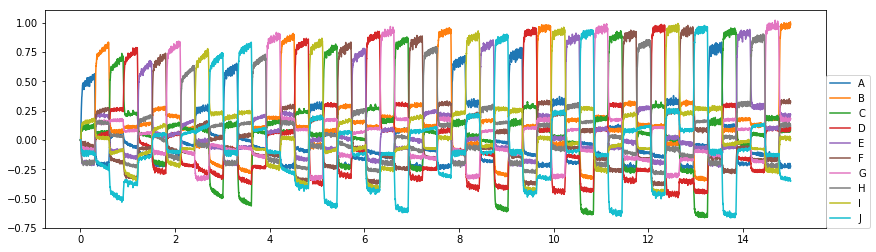

In [7]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [8]:
enc = sim.data[p_enc][-1]
dec = sim.data[p_dec][-1]

In [9]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

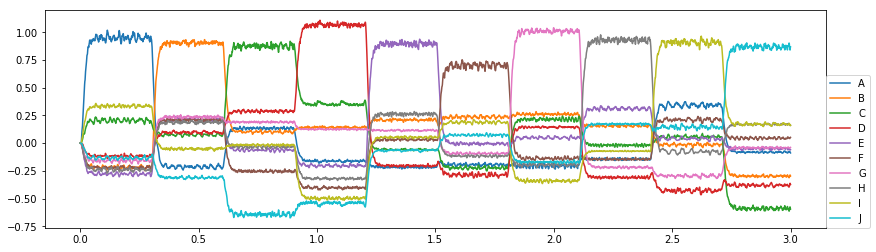

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

## Response to noisy vectors

In [11]:
base_mag = 1.

In [12]:
test_mags = (0.25, 0.3, 0.4)

In [13]:
test_vecs = []

for mag in test_mags:
    vec = vocab.parse(f"{mag}*I+{base_mag-mag}*A+{base_mag-mag}*F").v
    test_vecs.append(vec / np.linalg.norm(vec))

In [14]:
feed = BasicVecFeed(test_vecs, test_vecs, t_present, D, len(test_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(test_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

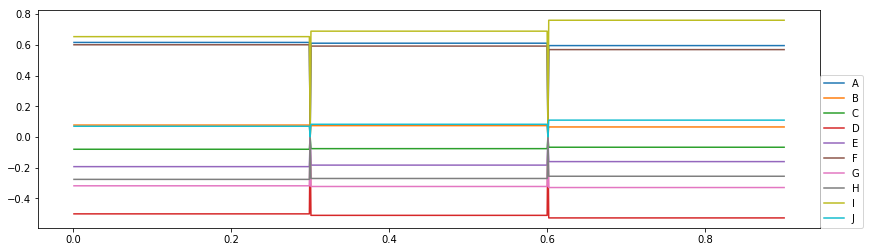

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_in], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

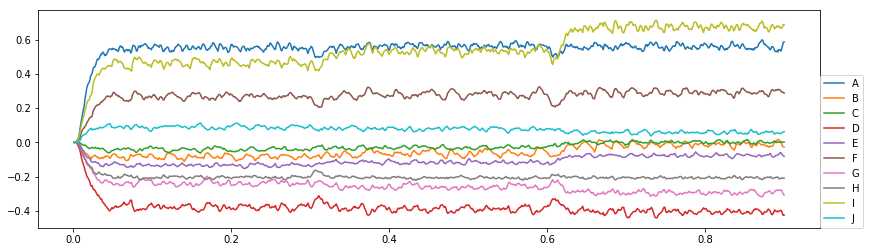

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Try all-to-all inhibition

It might have the desired effect?

In [72]:
t_present = 0.3
t_pause = 0.1
t_each = t_present + t_pause

td_pause = int(t_pause/dt)
td_present = int(t_present/dt)
td_each = int(t_each/dt)

In [155]:
rec_trans = -3e-5*np.ones((n_neurons, n_neurons))
np.fill_diagonal(rec_trans, 0.)#3e-3)

In [156]:
vecs = vocab.vectors
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    pause = nengo.Node(lambda t: feed.paused)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=0.005)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_trans, synapse=0.005)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

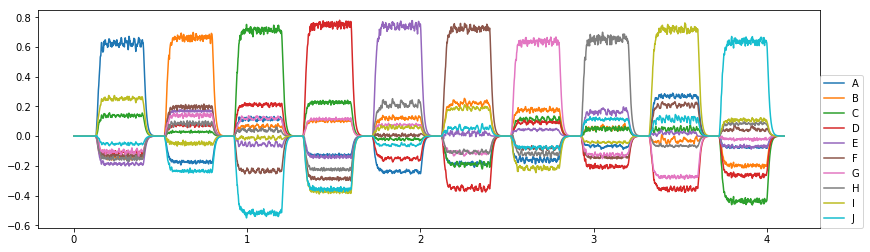

In [157]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
#plt.plot(test_sim.trange(), test_sim.data[p_paus], color='k', linestyle="--")
plt.legend(vocab.keys(), loc=(1, 0));

In [158]:
base_mag = 1.

In [159]:
test_mags = (0.25, 0.3, 0.4)

In [160]:
test_vecs = []

for mag in test_mags:
    vec = vocab.parse(f"{mag}*I+{base_mag-mag}*A+{base_mag-mag}*F").v
    test_vecs.append(vec / np.linalg.norm(vec))

In [164]:
feed = BasicVecFeed(test_vecs, test_vecs, t_present, D, len(test_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)
    
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=0.005)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_trans, synapse=0.005)
    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(test_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

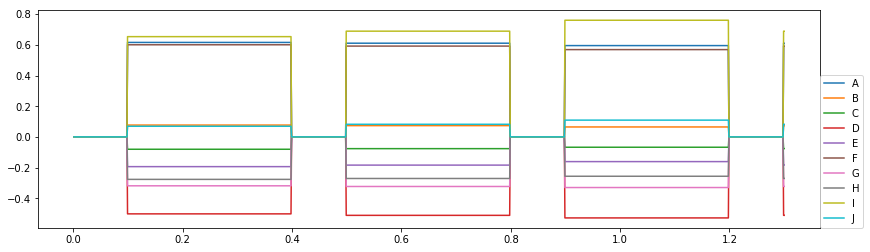

In [165]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_in], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

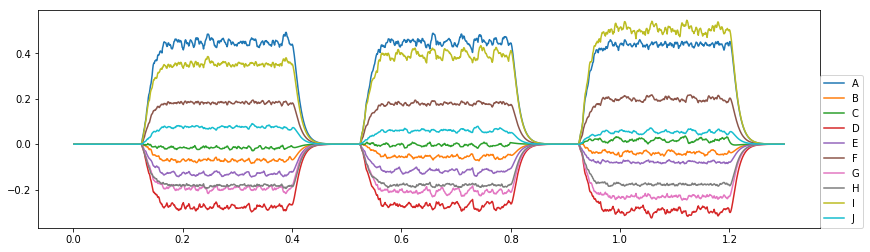

In [166]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));